# Difference-in-Difference (DiD)

- 출처
    - 실무로 통하는 인과추론 with 파이썬

In [1]:
!pip install toolz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [12]:
!pip install tidyfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [tidyfinance] [curl-cffi]areader]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [19]:
!pip install pyfixest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 3.5 MB/s eta 0:00:00a 0:00:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 3.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.2/607.2 kB 6.1 MB/s eta 0:00:00
  Created wheel for pyfixest: filename=pyfixest-0.30.2-cp310-cp310-macosx_11_0_arm64.whl size=2472651 sha256=370ddae650fe4c72c542076a9601be833bf7a0307347c449c84550020a66d844
  Stored in directory: /Users/kimsieun/Library/Caches/pip/wheels/3b/5b/80/a1c9daef56e29386e5317005354c6ed64b72034f35c7046fe5
Successfully built pyfixest
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [pyfixest]/14 [pyfixest]]es]ources]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] T

In [20]:
import pyfixest as pf

In [2]:
from toolz import *

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

In [3]:
import pandas as pd
import numpy as np

mkt_data = (pd.read_csv("./data/short_offline_mkt_south.csv")
            .astype({"date":"datetime64[ns]"}))

mkt_data.head()

,date,city,region,treated,tau,downloads,post
0,2021-05-01,5,S,0,0.0,51.0,0
1,2021-05-02,5,S,0,0.0,51.0,0
2,2021-05-03,5,S,0,0.0,51.0,0
3,2021-05-04,5,S,0,0.0,50.0,0
4,2021-05-05,5,S,0,0.0,49.0,0


처치 개입 전후 기간 확인

In [4]:
(mkt_data
 .assign(w = lambda d: d["treated"]*d["post"])
 .groupby(["w"])
 .agg({"date":[min, max]}))

/var/folders/qj/p1t8n_615hx2wgwh8350jg6h0000gn/T/ipykernel_14638/2583971365.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg({"date":[min, max]}))
/var/folders/qj/p1t8n_615hx2wgwh8350jg6h0000gn/T/ipykernel_14638/2583971365.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .agg({"date":[min, max]}))


date           
         min        max
w                      
0 2021-05-01 2021-06-01
1 2021-05-15 2021-06-01

In [33]:
did_data = (mkt_data
            .groupby(["treated", "post"])
            .agg({"downloads":"mean", "date": "min"}))

did_data

downloads       date
treated post                      
0       0     50.335034 2021-05-01
        1     50.556878 2021-05-15
1       0     50.944444 2021-05-01
        1     51.858025 2021-05-15

### 이중 차분법에 대한 접근법 3가지
1. 각 그룹별 평균을 집계 - 평균을 이용한 이중 차분법(Basic DID 2x2)
2. 각 집단의 사전→사후 변화량을 구한 후, 두 집단의 변화량 차이를 비교 - 시간에 따른 결과 변화 값을 이용한 이중차분법
3. 선형회귀
    - 기본 회귀 DID
    - Control DID (추가 통제 포함)
    - TWFE DID (이원고정효과 포함)


#### 평균을 이용한 이중 차분법(Basic DID 2x2)

In [34]:
y0_est = (did_data.loc[1].loc[0, "downloads"] # treated baseline
          # control evolution
          + did_data.loc[0].diff().loc[1, "downloads"]) 

att = did_data.loc[1].loc[1, "downloads"] - y0_est
att

np.float64(0.6917359536407233)

In [35]:
mkt_data.query("post==1").query("treated==1")["tau"].mean()

np.float64(0.7660316402518457)

#### 시간에 따른 결과 변화 값을 이용한 이중차분법

In [36]:
pre = mkt_data.query("post==0").groupby("city")["downloads"].mean()
post = mkt_data.query("post==1").groupby("city")["downloads"].mean()

delta_y = ((post - pre)
           .rename("delta_y")
           .to_frame()
           # add the treatment dummy
           .join(mkt_data.groupby("city")["treated"].max()))

delta_y.tail()

,delta_y,treated
city,,
192,0.555556,0
193,0.166667,0
195,0.420635,0
196,0.119048,0
197,1.595238,1


In [37]:
(delta_y.query("treated==1")["delta_y"].mean() 
 - delta_y.query("treated==0")["delta_y"].mean())

np.float64(0.6917359536407155)

DID 모형에 따른 실험군과 대조군의 추세 및 실험군의 가상적(반사실적) 추세

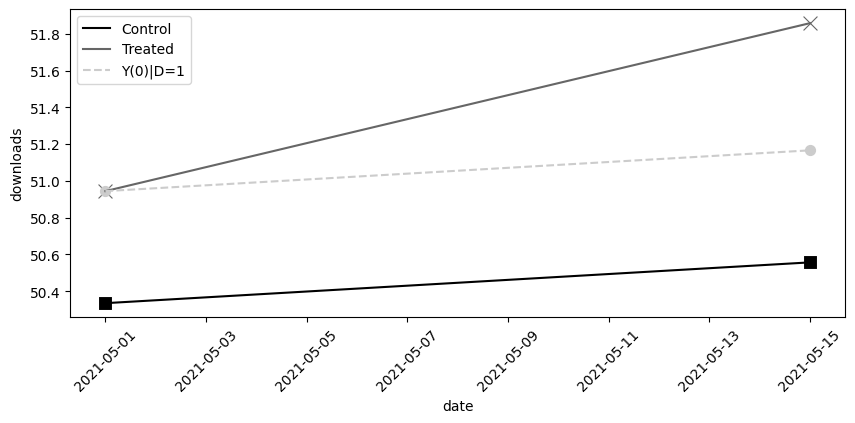

In [38]:
did_plt = did_data.reset_index()


plt.figure(figsize=(10,4))

sns.scatterplot(data=did_plt.query("treated==0"), x="date", y="downloads", s=100, color="C0", marker="s")
sns.lineplot(data=did_plt.query("treated==0"), x="date", y="downloads", label="Control", color="C0")

sns.scatterplot(data=did_plt.query("treated==1"), x="date", y="downloads", s=100, color="C1", marker="x")
sns.lineplot(data=did_plt.query("treated==1"), x="date", y="downloads", label="Treated", color="C1",)

plt.plot(did_data.loc[1, "date"], [did_data.loc[1, "downloads"][0], y0_est], color="C2", linestyle="dashed", label="Y(0)|D=1")
plt.scatter(did_data.loc[1, "date"], [did_data.loc[1, "downloads"][0], y0_est], color="C2", s=50)

plt.xticks(rotation = 45)
plt.legend()


### 선형회귀를 이용한 이중차분법(Regression DID)

#### 개입 전/후 기간을 하나의 블록으로 집계한 데이터

In [39]:
did_data = (mkt_data
            .groupby(["city", "post"])
            .agg({"downloads":"mean", "date": "min", "treated": "max"})
            .reset_index())

did_data.head()

,city,post,downloads,date,treated
0,5,0,50.642857,2021-05-01,0
1,5,1,50.166667,2021-05-15,0
2,15,0,49.142857,2021-05-01,0
3,15,1,49.166667,2021-05-15,0
4,20,0,48.785714,2021-05-01,0


 `statsmodels`와 `pyfixest`

DID 분석을 회귀 모형으로 구현할 때,
- **statsmodels (smf)** 은 파이썬에서 가장 널리 쓰이는 범용 회귀 패키지라 기본 구현을 설명하기에 적합하다.  
- 그러나 DID는 본질적으로 **패널 데이터 + 고정효과(FE) + 클러스터 표준오차**가 중요하다.  
  이를 편리하게 지원하는 패키지가 바로 **pyfixest**이다.

따라서 
- statsmodels로는 DID의 기본 원리를 쉽게 보여줄 수 있고,  
- pyfixest로는 실제 실증연구에서 사용하는 **FE-DID, TWFE, robust SE**를 더 직관적으로 구현할 수 있다.

In [40]:
import statsmodels.formula.api as smf

smf.ols(
    'downloads ~ treated*post', data=did_data
).fit().params["treated:post"]

np.float64(0.6917359536407082)

In [53]:
import pyfixest as pf

model = pf.feols("downloads ~ treated*post", data=did_data)

# DID 추정치 (treated:post 계수)
coef = model.coef()["treated:post"]
print("DID estimate:", coef)

DID estimate: 0.6917359536407451


### 블록디자인을 바탕으로 한 이중차분법
- DID를 추정할때 처치 전후로 각 값들을 그룹화하여 하지 않고 각 시점의 데이터를 모두 활용하는 방법
- 사전 평행 추세를 검정할 수 있다는 장점이 있음


/var/folders/qj/p1t8n_615hx2wgwh8350jg6h0000gn/T/ipykernel_14638/2621860921.py:7: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .assign(treated=lambda d: d.groupby("city")["treated"].transform(max))
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropri

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5]),
 [Text(0.5, 0, '2021-05-01'),
  Text(1.5, 0, '2021-05-02'),
  Text(2.5, 0, '2021-05-03'),
  Text(3.5, 0, '2021-05-04'),
  Text(4.5, 0, '2021-05-05'),
  Text(5.5, 0, '2021-05-06'),
  Text(6.5, 0, '2021-05-07'),
  Text(7.5, 0, '2021-05-08'),
  Text(8.5, 0, '2021-05-09'),
  Text(9.5, 0, '2021-05-10'),
  Text(10.5, 0, '2021-05-11'),
  Text(11.5, 0, '2021-05-12'),
  Text(12.5, 0, '2021-05-13'),
  Text(13.5, 0, '2021-05-14'),
  Text(14.5, 0, '2021-05-15'),
  Text(15.5, 0, '2021-05-16'),
  Text(16.5, 0, '2021-05-17'),
  Text(17.5, 0, '2021-05-18'),
  Text(18.5, 0, '2021-05-19'),
  Text(19.5, 0, '2021-05-20'),
  Text(20.5, 0, '2021-05-21'),
  Text(21.5, 0, '2021-05-22'),
  Text(22.5, 0, '2021-05-23'),
  Text(23.5, 0, '2021-05-24'),
  Text(24.5, 0, '2021-05-25'),
  Text(25.5, 0, '

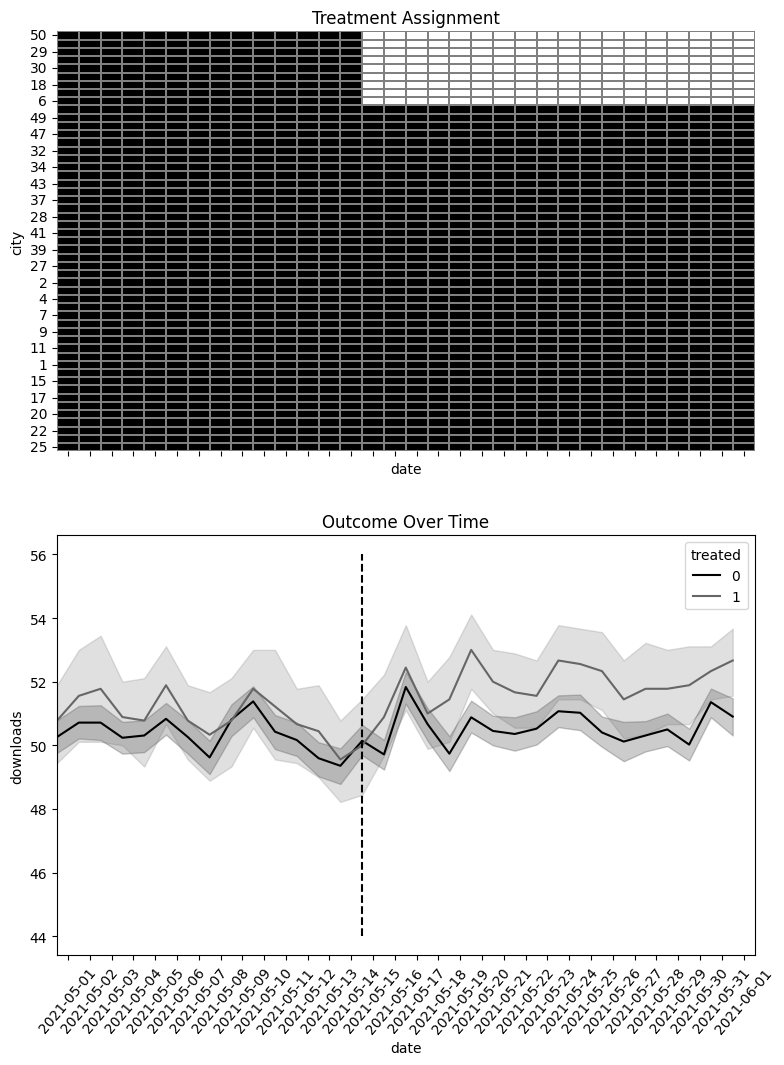

In [41]:
import matplotlib.ticker as plticker


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 12), sharex=True)

heat_plt = (mkt_data
            .assign(treated=lambda d: d.groupby("city")["treated"].transform(max))            
            .astype({"date":"str"})
            .assign(treated=mkt_data["treated"]*mkt_data["post"])
            .pivot(index="city", columns="date", values="treated")
            .reset_index()
            .sort_values(max(mkt_data["date"].astype(str)), ascending=False)
            .reset_index()
            .drop(columns=["city"])
            .rename(columns={"index":"city"})
            .set_index("city"))


sns.heatmap(heat_plt, cmap="gray", linewidths=0.01, linecolor="0.5", ax=ax1, cbar=False)

ax1.set_title("Treatment Assignment")


sns.lineplot(data=mkt_data.astype({"date":"str"}),
             x="date", y="downloads", hue="treated", ax=ax2)

loc = plticker.MultipleLocator(base=2.0)
# ax2.xaxis.set_major_locator(loc)
ax2.vlines("2021-05-15", mkt_data["downloads"].min(), mkt_data["downloads"].max(), color="black", ls="dashed", label="Interv.")
ax2.set_title("Outcome Over Time")

plt.xticks(rotation = 50)

In [42]:
m = smf.ols('downloads ~ treated*post', data=mkt_data).fit()

m.params["treated:post"]

np.float64(0.6917359536406855)

In [52]:
import pyfixest as pf

model = pf.feols("downloads ~ treated*post", data=mkt_data)

# DID 추정치 (treated:post 계수)
coef = model.coef()["treated:post"]
print("DID estimate:", coef)

DID estimate: 0.6917359536407436
